In this notebook, we will train a multimodal model that utilizes `BERT-large` as its text encoder and the largest variant of `Swin Transformer V2` as its vision encoder. For this training run, we will freeze the layers of both encoders, a technique known as feature extraction. The training set will be reduced to 6000 samples, with each image corresponding to a single caption.

All training will be performed on `Nvidia A100 GPU` in `Google Colab`.

First we need to install some extra libraries to use ROUGE as an evaluation metric.

In [ ]:
!pip install -q evaluate
!pip install -q rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Sun Jun 15 11:00:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             50W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import os
import kagglehub

path = kagglehub.dataset_download('adityajn105/flickr8k')

print(f'Path to dataset files: {path}')
print(f'Files and directories: {os.listdir(path)}')

Path to dataset files: /kaggle/input/flickr8k
Files and directories: ['captions.txt', 'Images']


In [ ]:
with open('/kaggle/input/flickr8k/captions.txt') as f:
    captions = f.read()

print(captions[:500])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3


In [ ]:
os.listdir('/kaggle/input/flickr8k/Images')[:5]

['3226254560_2f8ac147ea.jpg',
 '214543992_ce6c0d9f9b.jpg',
 '2366643786_9c9a830db8.jpg',
 '3368819708_0bfa0808f8.jpg',
 '2190227737_6e0bde2623.jpg']

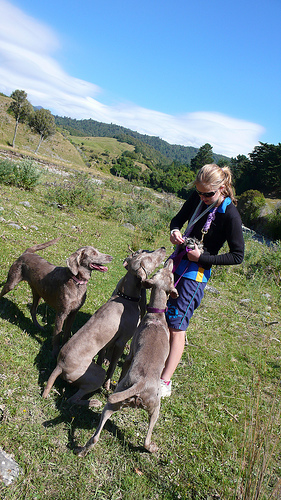

In [ ]:
from PIL import Image

Image.open('/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg')

In [ ]:
import io
import numpy as np
import pandas as pd

# Setting seed
np.random.seed(42)

# Load the captions string into a pandas DataFrame
buff = io.StringIO(captions)
df = pd.read_csv(buff)
# Construct the full path for each image file
df.image = df.image.apply (lambda im_path: os.path.join(path, 'Images', im_path))

df.head(10)

image  \
0  /kaggle/input/flickr8k/Images/1000268201_693b0...   
1  /kaggle/input/flickr8k/Images/1000268201_693b0...   
2  /kaggle/input/flickr8k/Images/1000268201_693b0...   
3  /kaggle/input/flickr8k/Images/1000268201_693b0...   
4  /kaggle/input/flickr8k/Images/1000268201_693b0...   
5  /kaggle/input/flickr8k/Images/1001773457_577c3...   
6  /kaggle/input/flickr8k/Images/1001773457_577c3...   
7  /kaggle/input/flickr8k/Images/1001773457_577c3...   
8  /kaggle/input/flickr8k/Images/1001773457_577c3...   
9  /kaggle/input/flickr8k/Images/1001773457_577c3...   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

In [ ]:
df = df.sort_values('image').reset_index(drop=True)

df.head(12).image.values

array(['/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg',
       '/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg'],
      dtype=object)

In [ ]:
df.image.nunique(), (8091 - 6000) // 2 + 1, (8091 - 6000) // 2

(8091, 1046, 1045)

In [ ]:
df['random_rank'] = df.groupby('image').image.transform(
    lambda x: np.random.permutation(len(x))
)
df['is_train'] = df['random_rank'] < 4

df.head(12)

image  \
0   /kaggle/input/flickr8k/Images/1000268201_693b0...   
1   /kaggle/input/flickr8k/Images/1000268201_693b0...   
2   /kaggle/input/flickr8k/Images/1000268201_693b0...   
3   /kaggle/input/flickr8k/Images/1000268201_693b0...   
4   /kaggle/input/flickr8k/Images/1000268201_693b0...   
5   /kaggle/input/flickr8k/Images/1001773457_577c3...   
6   /kaggle/input/flickr8k/Images/1001773457_577c3...   
7   /kaggle/input/flickr8k/Images/1001773457_577c3...   
8   /kaggle/input/flickr8k/Images/1001773457_577c3...   
9   /kaggle/input/flickr8k/Images/1001773457_577c3...   
10  /kaggle/input/flickr8k/Images/1002674143_1b742...   
11  /kaggle/input/flickr8k/Images/1002674143_1b742...   

                                              caption  random_rank  is_train  
0   A child in a pink dress is climbing up a set o...            1      True  
1               A girl going into a wooden building .            4     False  
2    A little girl climbing into a wooden playhouse .            2      True  
3   A little girl climbing the stairs to her playh...            0      True  
4   A little girl in a pink dress going into a woo...            3      True  
5     Two dogs on pavement moving toward each other .            3      True  
6   A black dog and a white dog with brown spots a...            1      True  
7   Two dogs of different breeds looking at each o...            2      True  
8          A black dog and a spotted dog are fighting            0      True  
9   A black dog and a tri-colored dog playing with...            4     False  
10  A little girl covered in paint sits in front o...            1      True  
11  A little girl is sitting in front of a large p...            0      True

In [ ]:
# Check the number of samples in the train set
df.is_train.sum()

np.int64(32364)

In [ ]:
df = df[df.random_rank == 1]

train_size = 6_000
train_df = df[:train_size]

res_df = df[train_size:]
test_size = 1046

test_df = res_df.iloc[:test_size].reset_index(drop=True)
valid_df = res_df.iloc[test_size:].reset_index(drop=True)

# Check the distribution
len(train_df), len(test_df), len(valid_df)

(6000, 1046, 1045)

In [ ]:
import torch
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set()

In [ ]:
from transformers import AutoTokenizer

llm_id = 'google-bert/bert-large-uncased'
tokenizer = AutoTokenizer.from_pretrained(llm_id)

tokenizer.add_special_tokens({'pad_token': '[PAD]'})

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

0

In [ ]:
def get_num_tokens(text: str) -> int:
    return len(tokenizer(text).input_ids)

df['tokens_per_description'] = df.caption.map(get_num_tokens)

df.head()

image  \
0   /kaggle/input/flickr8k/Images/1000268201_693b0...   
6   /kaggle/input/flickr8k/Images/1001773457_577c3...   
10  /kaggle/input/flickr8k/Images/1002674143_1b742...   
16  /kaggle/input/flickr8k/Images/1003163366_44323...   
23  /kaggle/input/flickr8k/Images/1007129816_e7944...   

                                              caption  random_rank  is_train  \
0   A child in a pink dress is climbing up a set o...            1      True   
6   A black dog and a white dog with brown spots a...            1      True   
10  A little girl covered in paint sits in front o...            1      True   
16  a man sleeping on a bench outside with a white...            1      True   
23  A man with glasses is wearing a beer can croch...            1      True   

    tokens_per_description  
0                       20  
6                       21  
10                      22  
16                      20  
23                      16

In [ ]:
df.tokens_per_description.max()

38

In [ ]:
from torch.utils.data import Dataset


class ImageCaptionDataset(Dataset):
    """Dataset that returns prcessed images with LVM processor and LLM tokenizer"""

    def __init__(self, df, processor, tokenizer, max_length=38):
        self.images = df.image.values.tolist()
        self.captions = df.caption.values.tolist()
        self.processor = processor
        self.tokenizer = tokenizer
        # Tokens from the text + [CLS] + [SEP] tokens
        self.max_length = max_length + 2

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Reading the image and getting pixel values
        image = Image.open(self.images[idx]).convert('RGB')
        im_inputs = self.processor(images=image, return_tensors='pt')
        pixel_values = im_inputs['pixel_values'].squeeze(0)

        # Tokenizing the caption and getting input ids
        caption = self.captions[idx]
        text_inputs = self.tokenizer(
            caption,
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_length,
            truncation=True
        )

        input_ids = torch.tensor(text_inputs.input_ids)
        input_ids[input_ids == tokenizer.pad_token_id] = -100

        return pixel_values, input_ids

In [ ]:
from transformers import AutoImageProcessor

lvm_id = 'microsoft/swinv2-large-patch4-window12-192-22k'
processor = AutoImageProcessor.from_pretrained(lvm_id, use_fast=True)

train_ds = ImageCaptionDataset(train_df, processor, tokenizer)
test_ds = ImageCaptionDataset(test_df, processor, tokenizer)
valid_ds = ImageCaptionDataset(valid_df, processor, tokenizer)

preprocessor_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

In [ ]:
# Verify the output of the dataset
train_ds[0]

(tensor([[[-0.6452, -0.0972, -0.5424,  ..., -2.0323, -2.0323, -2.0152],
          [-0.6794, -0.0629, -0.4397,  ..., -1.9638, -2.0152, -1.8953],
          [-0.7308,  0.0056, -0.3541,  ..., -1.9980, -1.9809, -1.9467],
          ...,
          [ 1.0673,  0.6734,  0.7762,  ...,  1.4954,  0.8276,  0.6734],
          [ 0.7762,  0.7591,  1.7694,  ...,  1.6153,  0.8104,  0.7419],
          [ 1.4954,  1.3927,  1.2899,  ...,  1.6495,  0.7762,  0.7762]],
 
         [[-0.4076,  0.3452, -0.1450,  ..., -1.9657, -1.9482, -1.8957],
          [-0.4601,  0.3803, -0.0049,  ..., -1.8256, -1.8782, -1.6331],
          [-0.5476,  0.4678,  0.1352,  ..., -1.8782, -1.8431, -1.7206],
          ...,
          [-0.1800, -0.3901,  0.0301,  ...,  1.8508,  1.2906,  1.1856],
          [-0.4251,  0.0301,  1.0805,  ...,  1.9559,  1.2381,  1.1856],
          [ 0.3102,  0.5378,  0.5028,  ...,  2.0084,  1.1856,  1.1856]],
 
         [[-0.0790,  0.5485, -0.1487,  ..., -1.7347, -1.7347, -1.7173],
          [-0.1138,  0.6356,

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
cpu_count = os.cpu_count() # 12
params = dict(
    shuffle=True,
    batch_size=batch_size,
    num_workers=cpu_count,
    pin_memory=True
)

train_dl = DataLoader(train_ds, **params)
test_dl = DataLoader(test_ds, **params)
valid_dl = DataLoader(valid_ds, **params)

In [ ]:
from transformers import VisionEncoderDecoderModel


model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(lvm_id, llm_id)

# ids
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

for param in model.encoder.parameters():
    param.requires_grad = False

for param in model.decoder.parameters():
    param.requires_grad = True

config.json:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/915M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/915M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.b

In [ ]:
model

VisionEncoderDecoderModel(
  (encoder): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0): Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=6, bias=False)
                  )
                  (query): Linear(in_features=192, out_features=192, bias=True)
                  (key): Linear(in_features=192, out_features=192, 

In [ ]:
import evaluate
from torch.optim import AdamW
from transformers import get_scheduler

epochs = 15
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.AdamW(trainable_parameters, lr=5e-5)
num_training_steps = epochs * len(train_dl)
num_warmup_steps = num_training_steps // 5

scheduler = get_scheduler(name='linear', optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

metric = evaluate.load('rouge')

In [ ]:
from tqdm import tqdm

def evaluate_with_rouge(model, dl, tokenizer, metric, device):
    """
     Method to evaluate model's performance on a given dataset using the ROUGE metric

    :param model: The model to evaluate
    :param dl: The DataLoader for the evaluation data
    :param tokenizer: The tokenizer used to decode predictions and labels
    :param metric: The ROUGE metric object from the `evaluate` library
    :param device: The device (CPU or CUDA) for evaluation
    :return: A dictionary with the computed metrics: rouge1, rouge2, rougeL and rougeLsum
    """
    model.eval()

    progress_bar = tqdm(dl, desc='Calculating Rouge', leave=False)

    for pixel_values, input_ids in progress_bar:
        pixel_values = pixel_values.to(device)
        labels = input_ids.to(device)

        # Disable gradient calculation for faster and less memory-intensive inference
        with torch.no_grad():
            outputs = model(
                pixel_values=pixel_values,
                labels=labels
            )

        # Get the most likely token ID for each position in the sequence
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        # Decode the predicted token IDs into text
        predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        # Minor cleanup on the predictions to improve scoring alignment
        predictions = [pred_caption.replace('.', '') for pred_caption in predictions]
        # Labels use -100 to mask padding, replace with [PAD] token id for correct decoding
        references = [
            tokenizer.decode(
                [tokenizer.pad_token_id if token == -100 else token for token in reference],
                skip_special_tokens=True
            )
            for reference in labels.tolist()
        ]
        # Add the current batch of predictions and references to the metric accumulator
        metric.add_batch(predictions=predictions, references=references)

    return metric.compute()

In [ ]:
def train_one_epoch(model, dl, optimizer, scheduler, device, tokenizer, metric):
    """
    Function that trains the model for a single epoch

    :param model: The model to be trained
    :param dl: DataLoader for the training data
    :param optimizer: The optimizer for updating model weights
    :param scheduler: The learning rate scheduler
    :param device: The device for training
    :param tokenizer: BERT tokenizer for decoding
    :param metric: The metric object to evaluate rouge1, rouge2, rougeL and rougeLsum
    :return: A dictionary with loss and computed metrics: rouge1, rouge2, rougeL and rougeLsum
    """
    model.train()

    total_loss = 0
    progress_bar = tqdm(dl, desc='Training', leave=False)

    for pixel_values, input_ids in progress_bar:
        # Move data to the specified computation device.
        pixel_values = pixel_values.to(device)
        labels = input_ids.to(device)

        # Perform a forward pass through the model.
        # The model returns outputs including the loss.
        outputs = model(
            pixel_values=pixel_values,
            labels=labels
        )
        loss = outputs.loss

        # Backpropagation: compute gradients, update weights, and clear gradients.
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Update the progress bar with the loss for the current batch.
        progress_bar.set_postfix(loss=loss.item())

        total_loss += loss.item()

    # Calculate the average loss over all batches.
    avg_loss = total_loss / len(dl)

    # Evaluate the model on the training data at the end of the epoch.
    rouge_scores = evaluate_with_rouge(model, dl, tokenizer, metric, device)

    return {'loss': avg_loss, **rouge_scores}

In [ ]:
def evaluate(model, dl, device, tokenizer, metric):
    """
    Method to evaluate the model on a given dataset

    :param model: The model to evaluate
    :param dl: DataLoader for the evaluation data
    :param device: The device for evaluation
    :param tokenizer: BERT tokenizer for decoding predictions
    :param metric: The metric object to evaluate rouge1, rouge2, rougeL and rougeLsum
    :return: A dictionary with loss and computed metrics: rouge1, rouge2, rougeL and rougeLsum
    """
    model.eval()

    total_loss = 0
    progress_bar = tqdm(dl, desc='Evaluating', leave=False)

    for pixel_values, input_ids in progress_bar:
        pixel_values = pixel_values.to(device)
        labels = input_ids.to(device)

        # Disable gradient calculation for inference.
        with torch.no_grad():
            outputs = model(
                pixel_values=pixel_values,
                labels=labels
            )

        # Accumulate the loss for the batch.
        loss = outputs.loss
        total_loss += loss.item()

        # Update the progress bar with the current batch's loss.
        progress_bar.set_postfix(loss=loss.item())

    # Calculate the average loss across all batches.
    avg_loss = total_loss / len(dl)

    # Use the separate function to get ROUGE scores for the whole dataset.
    rouge_scores = evaluate_with_rouge(model, dl, tokenizer, metric, device)

    # Return a dictionary with the average loss and the ROUGE scores.
    return {'loss': avg_loss, **rouge_scores}

In [ ]:
class History:
    """Plcaholder to store training metrics and loss in a structured format"""

    def __init__(self):
        self._history = {'loss': [], 'rouge1': [], 'rouge2': [], 'rougeL': [], 'rougeLsum': []}

    def update(self, metrics):
        self._history ['loss'].append(metrics.get('loss', 0.0))
        self._history ['rouge1'].append(metrics.get('rouge1', 0.0))
        self._history ['rouge2'].append(metrics.get('rouge2', 0.0))
        self._history ['rougeL'].append(metrics.get('rougeL', 0.0))
        self._history ['rougeLsum'].append(metrics.get('rougeLsum', 0.0))

    def to_df(self):
        return pd.DataFrame(self._history)

    @property
    def hist_metrics(self):
        return self._history

In [ ]:
train_history = History()
test_history = History()

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}/{epochs}')

    train_metrics = train_one_epoch(model, train_dl, optimizer, scheduler, device, tokenizer, metric)
    test_metrics = evaluate(model, test_dl, device, tokenizer, metric)

    print(f"Train | Loss: {train_metrics['loss']:.3f} | Rouge1: {train_metrics['rouge1']:.5f} | Rouge2: {train_metrics['rouge2']:.5f} | RougeL: {train_metrics['rougeL']:.5f} | RougeLsum: {train_metrics['rougeLsum']:.5f}")
    print(f" Test | Loss: {test_metrics['loss']:.3f} | Rouge1: {test_metrics['rouge1']:.5f} | Rouge2: {test_metrics['rouge2']:.5f} | RougeL: {test_metrics['rougeL']:.5f} | RougeLsum: {test_metrics['rougeLsum']:.5f}\n")

    train_history.update(train_metrics)
    test_history.update(test_metrics)

    model.save_pretrained(f'model_epoch_{epoch}')

Epoch 1/15


Training:   0%|          | 0/188 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Train | Loss: 7.142 | Rouge1: 0.03186 | Rouge2: 0.00000 | RougeL: 0.03182 | RougeLsum: 0.03180
 Test | Loss: 5.536 | Rouge1: 0.03161 | Rouge2: 0.00000 | RougeL: 0.03157 | RougeLsum: 0.03155

Epoch 2/15


Train | Loss: 5.300 | Rouge1: 0.00461 | Rouge2: 0.00000 | RougeL: 0.00461 | RougeLsum: 0.00460
 Test | Loss: 5.284 | Rouge1: 0.00480 | Rouge2: 0.00000 | RougeL: 0.00482 | RougeLsum: 0.00481

Epoch 3/15


Train | Loss: 4.963 | Rouge1: 0.02084 | Rouge2: 0.00003 | RougeL: 0.02073 | RougeLsum: 0.02078
 Test | Loss: 5.205 | Rouge1: 0.01775 | Rouge2: 0.00000 | RougeL: 0.01771 | RougeLsum: 0.01772

Epoch 4/15


Train | Loss: 4.650 | Rouge1: 0.21882 | Rouge2: 0.00899 | RougeL: 0.20074 | RougeLsum: 0.20069
 Test | Loss: 4.795 | Rouge1: 0.19312 | Rouge2: 0.00649 | RougeL: 0.18091 | RougeLsum: 0.18097

Epoch 5/15


Train | Loss: 4.342 | Rouge1: 0.25045 | Rouge2: 0.02318 | RougeL: 0.22217 | RougeLsum: 0.22210
 Test | Loss: 4.663 | Rouge1: 0.21012 | Rouge2: 0.01506 | RougeL: 0.18893 | RougeLsum: 0.18901

Epoch 6/15


Train | Loss: 4.109 | Rouge1: 0.26759 | Rouge2: 0.02627 | RougeL: 0.23267 | RougeLsum: 0.23261
 Test | Loss: 4.687 | Rouge1: 0.20549 | Rouge2: 0.01537 | RougeL: 0.18190 | RougeLsum: 0.18187

Epoch 7/15


Train | Loss: 3.898 | Rouge1: 0.25768 | Rouge2: 0.03174 | RougeL: 0.22399 | RougeLsum: 0.22393
 Test | Loss: 4.720 | Rouge1: 0.19388 | Rouge2: 0.01481 | RougeL: 0.17351 | RougeLsum: 0.17322

Epoch 8/15


Train | Loss: 3.701 | Rouge1: 0.28231 | Rouge2: 0.03962 | RougeL: 0.23726 | RougeLsum: 0.23715
 Test | Loss: 4.792 | Rouge1: 0.19728 | Rouge2: 0.01656 | RougeL: 0.16963 | RougeLsum: 0.16956

Epoch 9/15


Train | Loss: 3.510 | Rouge1: 0.30154 | Rouge2: 0.04384 | RougeL: 0.25944 | RougeLsum: 0.25949
 Test | Loss: 4.895 | Rouge1: 0.19794 | Rouge2: 0.01580 | RougeL: 0.17240 | RougeLsum: 0.17197

Epoch 10/15


Train | Loss: 3.337 | Rouge1: 0.30397 | Rouge2: 0.05267 | RougeL: 0.26769 | RougeLsum: 0.26762
 Test | Loss: 4.913 | Rouge1: 0.18943 | Rouge2: 0.01649 | RougeL: 0.16774 | RougeLsum: 0.16792

Epoch 11/15


Train | Loss: 3.202 | Rouge1: 0.32074 | Rouge2: 0.05895 | RougeL: 0.27874 | RougeLsum: 0.27863
 Test | Loss: 5.007 | Rouge1: 0.19268 | Rouge2: 0.01757 | RougeL: 0.16845 | RougeLsum: 0.16837

Epoch 12/15


Train | Loss: 3.068 | Rouge1: 0.31023 | Rouge2: 0.05836 | RougeL: 0.27933 | RougeLsum: 0.27952
 Test | Loss: 5.091 | Rouge1: 0.17438 | Rouge2: 0.01621 | RougeL: 0.15485 | RougeLsum: 0.15486

Epoch 13/15


Train | Loss: 2.967 | Rouge1: 0.33756 | Rouge2: 0.07124 | RougeL: 0.30493 | RougeLsum: 0.30487
 Test | Loss: 5.185 | Rouge1: 0.18077 | Rouge2: 0.01520 | RougeL: 0.16003 | RougeLsum: 0.15990

Epoch 14/15


Train | Loss: 2.894 | Rouge1: 0.34210 | Rouge2: 0.07047 | RougeL: 0.30733 | RougeLsum: 0.30731
 Test | Loss: 5.205 | Rouge1: 0.18470 | Rouge2: 0.01625 | RougeL: 0.16387 | RougeLsum: 0.16394

Epoch 15/15


Train | Loss: 2.845 | Rouge1: 0.34966 | Rouge2: 0.07507 | RougeL: 0.31289 | RougeLsum: 0.31279
 Test | Loss: 5.214 | Rouge1: 0.18558 | Rouge2: 0.01721 | RougeL: 0.16505 | RougeLsum: 0.16504



In [ ]:
train_history.to_df()

loss    rouge1    rouge2    rougeL  rougeLsum
0   7.142277  0.031855  0.000000  0.031815   0.031797
1   5.300340  0.004606  0.000000  0.004608   0.004597
2   4.962530  0.020843  0.000034  0.020735   0.020781
3   4.650036  0.218825  0.008991  0.200738   0.200694
4   4.342337  0.250452  0.023179  0.222172   0.222102
5   4.108924  0.267593  0.026269  0.232667   0.232606
6   3.898222  0.257681  0.031740  0.223992   0.223933
7   3.700681  0.282314  0.039619  0.237265   0.237145
8   3.509506  0.301544  0.043835  0.259438   0.259491
9   3.336962  0.303971  0.052672  0.267687   0.267625
10  3.201645  0.320744  0.058952  0.278745   0.278633
11  3.068334  0.310233  0.058357  0.279326   0.279520
12  2.967274  0.337560  0.071240  0.304928   0.304873
13  2.894229  0.342097  0.070472  0.307327   0.307307
14  2.844695  0.349660  0.075072  0.312892   0.312795

In [ ]:
test_history.to_df()

loss    rouge1    rouge2    rougeL  rougeLsum
0   5.535772  0.031609  0.000000  0.031566   0.031554
1   5.283674  0.004796  0.000000  0.004817   0.004814
2   5.205302  0.017752  0.000000  0.017708   0.017716
3   4.794764  0.193123  0.006493  0.180907   0.180973
4   4.663224  0.210119  0.015065  0.188935   0.189007
5   4.687183  0.205490  0.015365  0.181896   0.181874
6   4.720208  0.193881  0.014814  0.173507   0.173218
7   4.792346  0.197278  0.016563  0.169628   0.169557
8   4.894548  0.197941  0.015798  0.172397   0.171973
9   4.913281  0.189426  0.016491  0.167743   0.167917
10  5.007222  0.192680  0.017573  0.168452   0.168370
11  5.090747  0.174380  0.016208  0.154849   0.154861
12  5.185380  0.180773  0.015195  0.160026   0.159899
13  5.205053  0.184700  0.016250  0.163873   0.163940
14  5.214345  0.185578  0.017214  0.165054   0.165041

In [ ]:
pd.DataFrame(evaluate(model, train_dl, device, tokenizer, metric), index=['Train Metrics']).T

Train Metrics
loss            2.592196
rouge1          0.349760
rouge2          0.075063
rougeL          0.312774
rougeLsum       0.312923

In [ ]:
pd.DataFrame(evaluate(model, test_dl, device, tokenizer, metric), index=['Test Metrics']).T

Test Metrics
loss           5.214430
rouge1         0.185769
rouge2         0.017100
rougeL         0.165144
rougeLsum      0.165108

In [ ]:
pd.DataFrame(evaluate(model, valid_dl, device, tokenizer, metric), index=['Validation Metrics']).T

Validation Metrics
loss                 5.185208
rouge1               0.199766
rouge2               0.018422
rougeL               0.176723
rougeLsum            0.176698

In [ ]:
# Start every new caption with the special [CLS] token, otherwise the generating will fail
model.generation_config.decoder_start_token_id = tokenizer.cls_token_id

In [ ]:
pixel_values = train_ds[3][0].unsqueeze(0)

# Trying to generate a caption
predictions = tokenizer.decode(model.generate(pixel_values=pixel_values.to(device))[0], skip_special_tokens=True)
caption = predictions.replace('.', '')

caption

'man sitting a a a a'

In [ ]:
# Select random images from the validation set
ids = np.random.choice(np.arange(len(valid_dl)), 15, replace=False).astype(int)

ids

array([ 5, 16, 31,  2, 26, 28, 11, 15, 30,  9, 22, 24,  4, 18,  3])

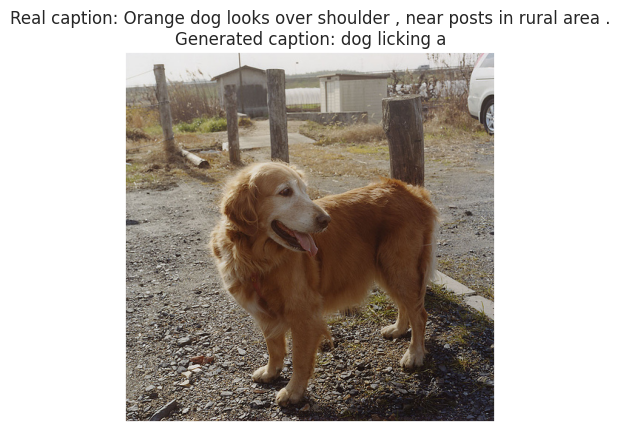

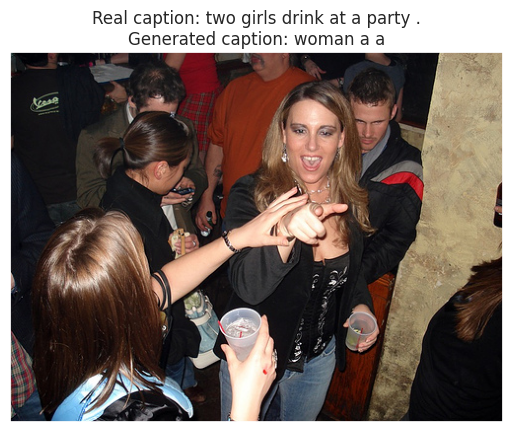

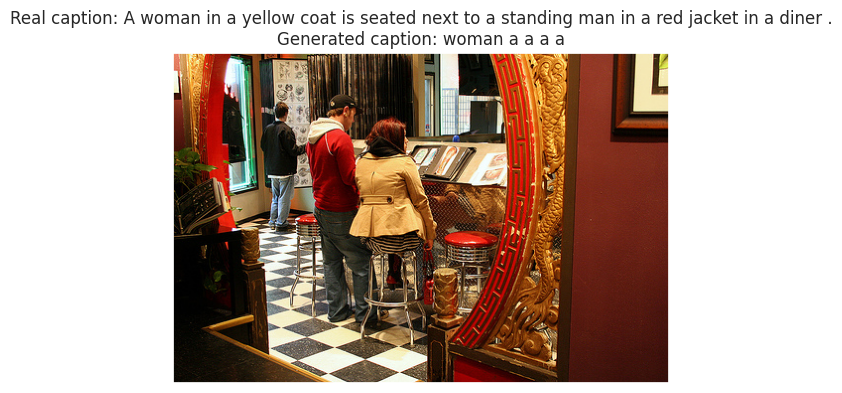

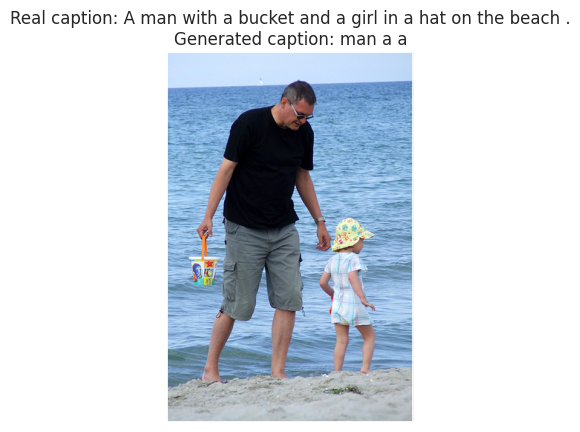

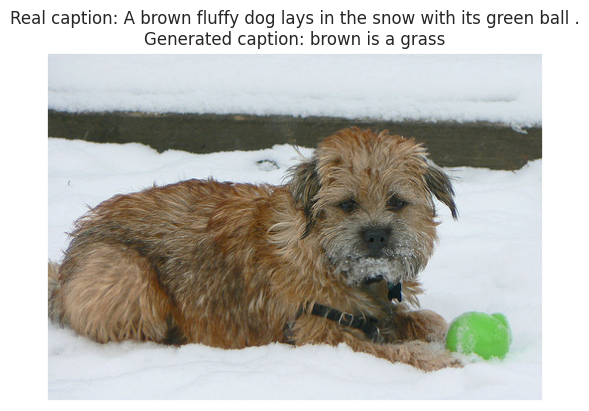

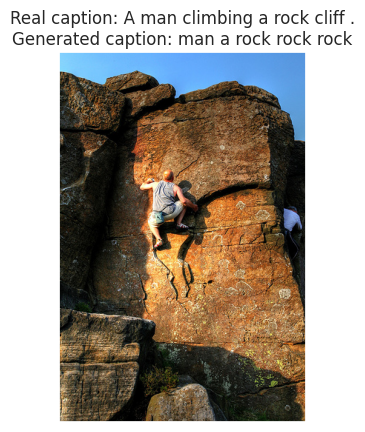

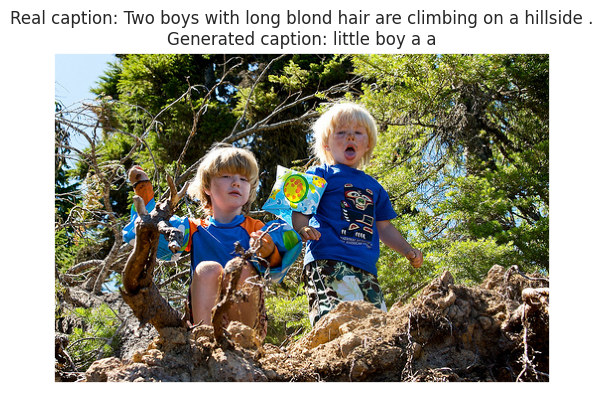

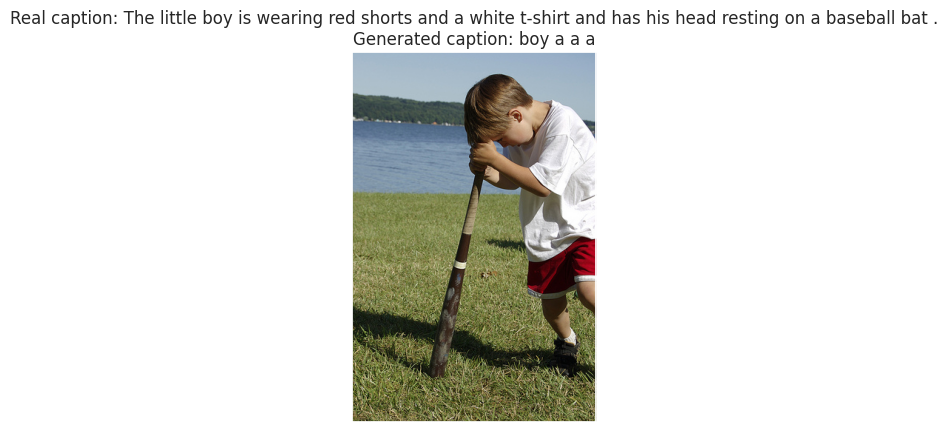

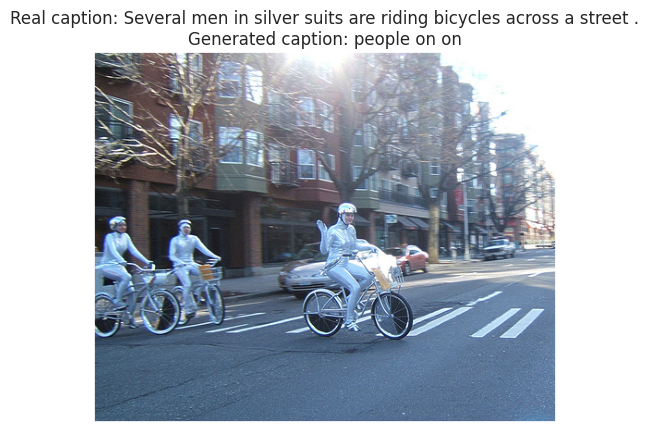

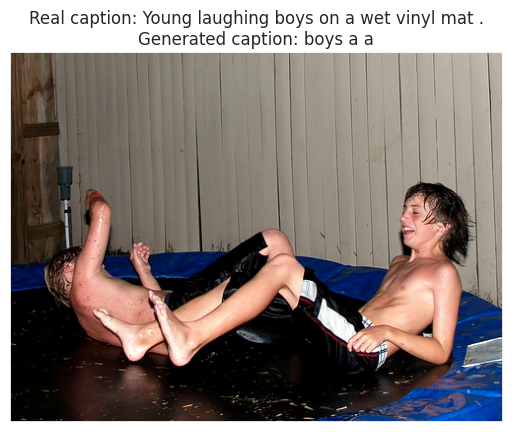

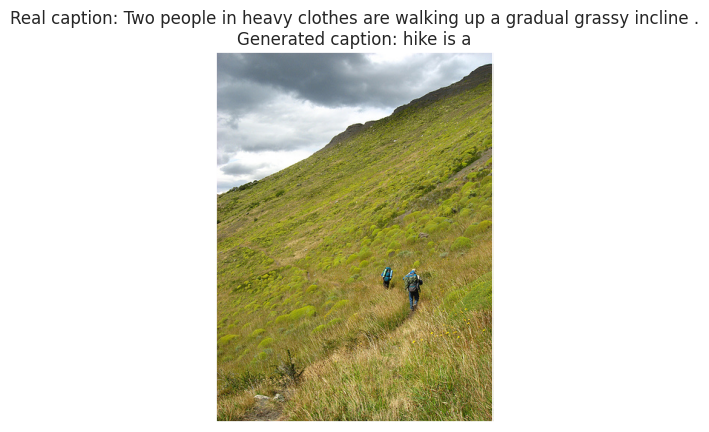

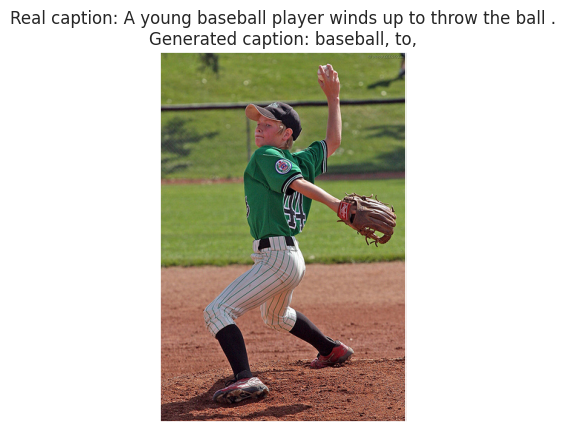

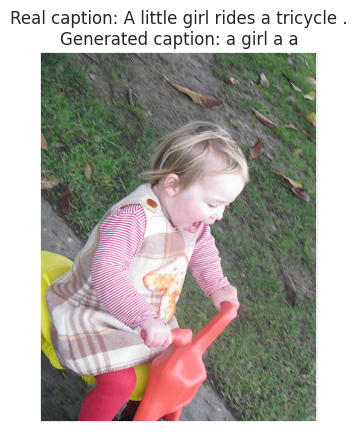

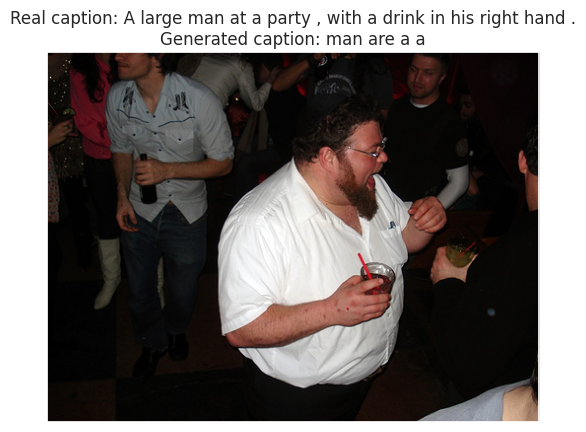

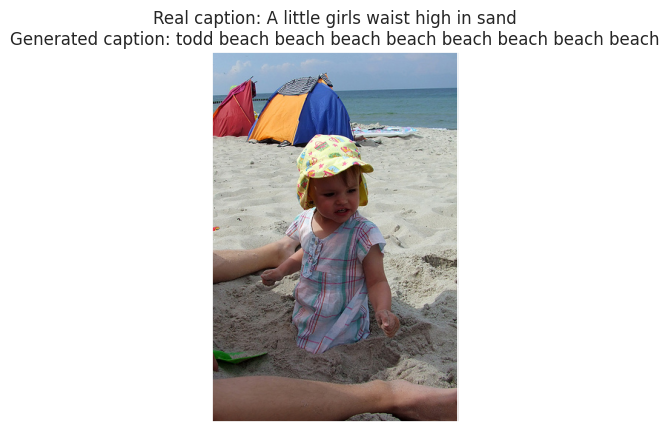

In [ ]:
for i in ids:
    pixel_values = valid_ds[i][0].unsqueeze(0).to(device)
    predictions = tokenizer.decode(model.generate(pixel_values=pixel_values)[0], skip_special_tokens=True)
    fact = valid_df.loc[int(i), 'caption']
    caption = predictions.replace('.', '').strip()

    im = plt.imread(valid_df.iloc[i].image)
    title = f'Real caption: {fact}\nGenerated caption: {caption}'

    plt.imshow(im)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()